#Notebook: MLP Model
##Author: Lucía Núñez Calvo
###Date: 12/04/2024

####Summary

This notebook shows two implementations of the Multilayer Perceptron (**MLP**) model. The first implementation tests without cross-validation, while the second implementation tests using cross-validation.

In the first part of the notebook, the MLP model is trained and evaluated **without** using **cross-validation** techniques. This allows the performance of the model to be observed on a single set of training and test data, providing an initial insight into its performance.

Subsequently, the second implementation is presented, where **cross-validation** is applied to evaluate the model. This technique splits the dataset into several parts and performs multiple training and evaluations. Cross-validation provides a more robust and reliable estimate of model performance by reducing the risk of overfitting and providing better generalisation over unseen data.

Each combination of these implementations (with and without cross-validation) has been realised using two types of audio analysis features: Mel Frequency Cepstral Coefficients (**MFCC**) and Linear Predictive Coding (**LPC**).

At the end of the notebook, a comparison of the results obtained from both implementations is performed. For this purpose, **confusion matrices** and graphs reflecting the **Accuracy**, **Recall** and **F1-score** metrics of the different classes have been created. These visualisations allow a detailed comparison of the performance of the model in each approach, providing a clear view of the strengths and weaknesses of each method and helping to determine the best strategy for classification.

----

####Structure of the notebook

0.   Load features
1.   MLP without cross-validation
2.   MLP with cross-validation
3.   Checking the results
4.   Save the results

In [1]:
import os
import joblib
import librosa
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from scipy.linalg import toeplitz, solve_toeplitz, LinAlgError
from sklearn.metrics import classification_report, confusion_matrix

## 0. Load features

In [3]:
features_mfcc = np.load('features_mfcc.npy')
features_lpc = np.load('features_lpc.npy')
labels = np.load('labels.npy')

In [4]:
print("Length of MFCC features:", len(features_mfcc))
print("Length of LPC features:", len(features_lpc))
print("Length of labels:", len(labels))

Length of MFCC features: 432
Length of LPC features: 432
Length of labels: 432


## 1. MLP without cross-validation

In [3]:
def create_model(features, labels):
  '''
  This function creates and trains an MLP model.

  Input:
    - features: (array) Set of input features for the model.
    - labels: (array) Labels corresponding to the input features.

  Output:
    - model: (MLPClassifier) Trained MLP model.
    - y_test: (array) Labels of the test set.
    - y_pred: (array) Labels predicted by the model in the test set.
  '''
  # Division of data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

  # Scaling the features
  scaler = StandardScaler() # To ensure that all inputs have the same weight and contribute equally during training.
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Training the model
  model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
  model.fit(X_train, y_train)

  # Evaluation of the model
  y_pred = model.predict(X_test)


  return model, y_test, y_pred

In [39]:
# Tests with MFCC features
model_mfcc, y_test_mfcc, y_pred_mfcc = create_model(features_mfcc, labels)
print(classification_report(y_test_mfcc, y_pred_mfcc))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        43
           1       0.94      1.00      0.97        30
           2       0.91      0.91      0.91        23
           3       1.00      1.00      1.00        34

    accuracy                           0.95       130
   macro avg       0.95      0.96      0.95       130
weighted avg       0.95      0.95      0.95       130



In [20]:
# Tests with LPC features
model_lpc, y_test_lpc, y_pred_lpc = create_model(features_lpc, labels)
print(classification_report(y_test_lpc, y_pred_lpc))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92        43
           1       1.00      1.00      1.00        30
           2       0.94      0.74      0.83        23
           3       1.00      1.00      1.00        34

    accuracy                           0.95       130
   macro avg       0.95      0.93      0.94       130
weighted avg       0.95      0.95      0.94       130



## 2. MLP with cross-validation

In [21]:
def create_model_with_cross_validation(features, labels):
    '''
    This function creates and trains an MLP model whit cross-validation.
    During each iteration of the cross-validation, the actual labels of the test set (y_test) and the labels predicted by the model (y_pred) are accumulated.
    This is done to combine the results of all the folds and get an overall evaluation of the model.

    Input:
      - features: (array) Set of input features for the model.
      - labels: (array) Labels corresponding to the input features.

    Output:
      - model: (MLPClassifier) Trained MLP model.
      - y_test: (array) Labels of the test set.
      - y_pred: (array) Labels predicted by the model in the test set.
    '''
    y_test_accum = []
    y_pred_accum = []


    # Cross-validation with 5 folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(features, labels):

        # Division of data into training and test sets
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Scaling the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Training the model
        model = MLPClassifier(alpha=0.01, batch_size=128, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)
        model.fit(X_train, y_train)

        # Evaluation of the model
        y_pred = model.predict(X_test)

        # Accumulate results
        y_test_accum.extend(y_test)
        y_pred_accum.extend(y_pred)

    return model, np.array(y_test_accum), np.array(y_pred_accum)

In [37]:
# Tests with MFCC features and cross-validation
model_mfcc_cv, scaler_mfcc_cv, y_test_mfcc_cv, y_pred_mfcc_cv = create_model_with_cross_validation(features_mfcc, labels)
print(classification_report(y_test_mfcc_cv, y_pred_mfcc_cv))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       1.00      1.00      1.00       108
           2       0.93      0.92      0.93       108
           3       0.98      1.00      0.99       108

    accuracy                           0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432



In [42]:
# Tests with LPC features and cross-validation
model_lpc_cv, scaler_lpc_cv, y_test_lpc_cv, y_pred_lpc_cv = create_model_with_cross_validation(features_lpc, labels)
print(classification_report(y_test_lpc_cv, y_pred_lpc_cv))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       108
           1       1.00      1.00      1.00       108
           2       0.95      0.81      0.87       108
           3       1.00      1.00      1.00       108

    accuracy                           0.94       432
   macro avg       0.94      0.94      0.94       432
weighted avg       0.94      0.94      0.94       432



## 3.   Checking the results




In [43]:
# Variables containing the labels the test and the labels predicted by the model in the test set
y_tests = [y_test_mfcc, y_test_mfcc_cv, y_test_lpc, y_test_lpc_cv]
y_preds = [y_pred_mfcc, y_pred_mfcc_cv, y_pred_lpc, y_pred_lpc_cv]

# Variable containing the titles for the representations
titles = ['Features extracted with MFCC and MLP model', 'Features extracted with MFCC and MLP model with cross-validation',
          'Features extracted with LPC and MLP model', 'Features extracted with LPC and MLP model with cross-validation']

In [ ]:
def display_confusion_matrices(y_tests, y_preds, titles):
    '''
    Function that displays confusion matrices for multiple models.

    Input:
      - y_tests: (list) List of arrays with the true values (y_test) of each model.
      - y_preds: (list) List of arrays with the predicted values (y_pred) of each model.
      - titles (list) List of titles for each subplot.
    '''
    num_models = len(y_tests)
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i in range(num_models):
        conf_matrix = confusion_matrix(y_tests[i], y_preds[i])
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[i])
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

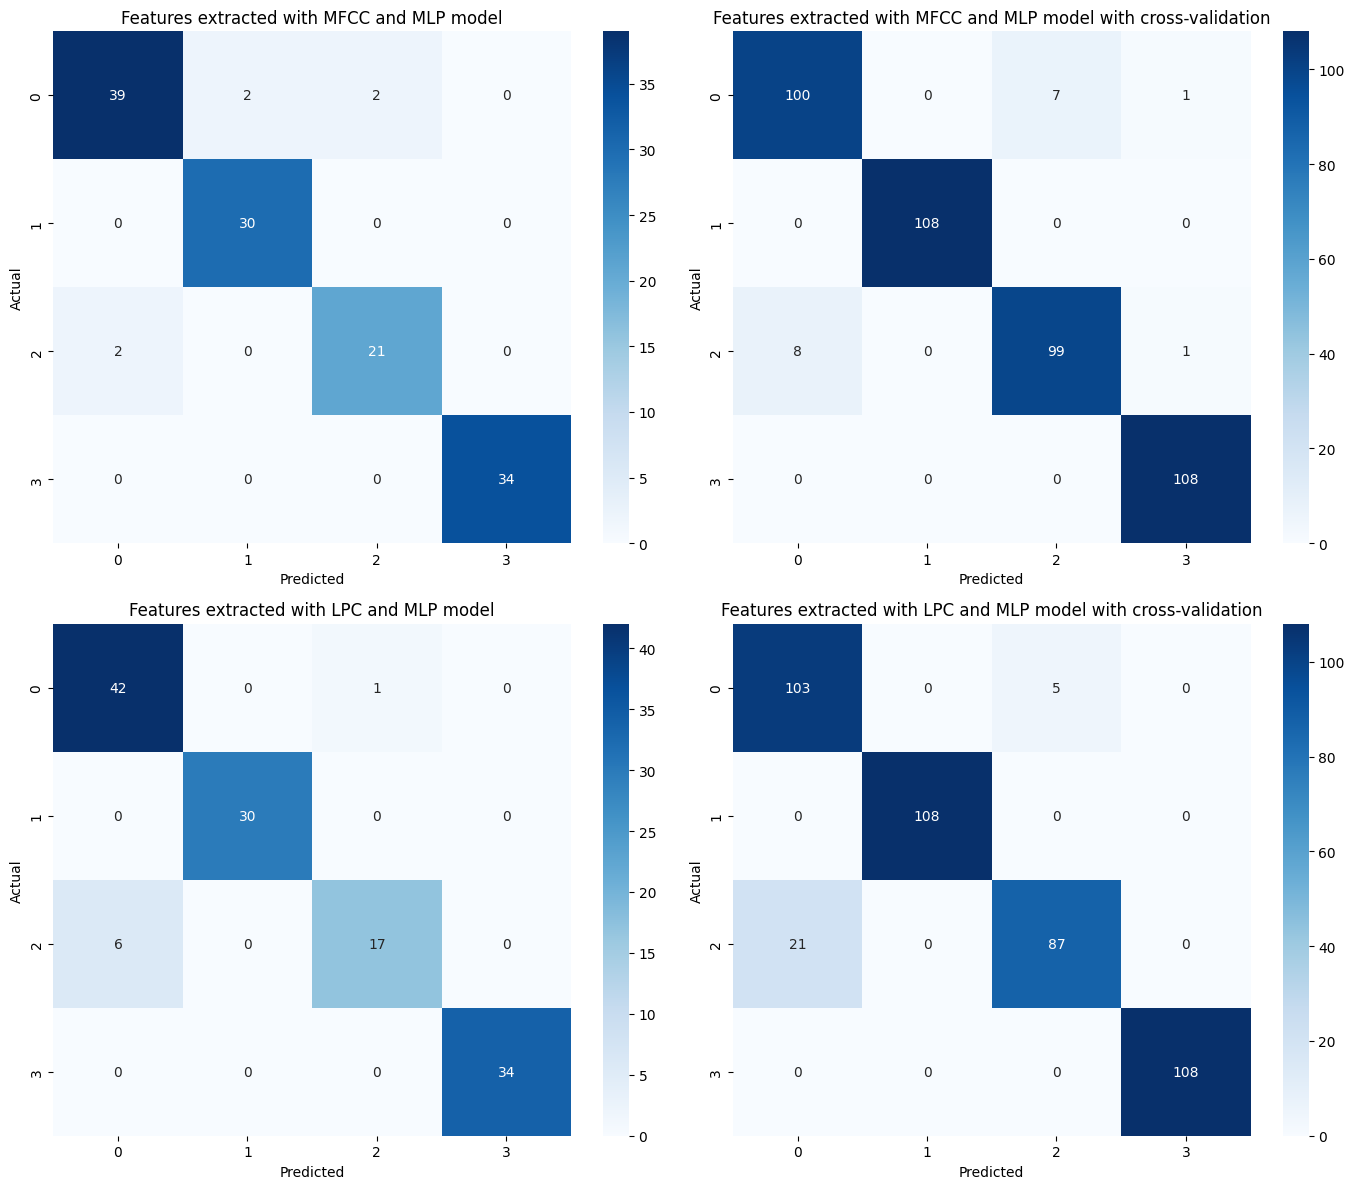

In [44]:
display_confusion_matrices(y_tests, y_preds, titles)

In [ ]:
def plot_classification_metrics_multiple(y_tests, y_preds, titles):
    '''
    Function that displays the ‘Precision’ ‘Recall’ and ‘F1-score’ for multiple models on a graph.

    Input:
      - y_tests: (list) List of arrays with the true values (y_test) of each model.
      - y_preds: (list) List of arrays with the predicted values (y_pred) of each model.
      - titles (list) List of titles for each subplot.
    '''

    num_models = len(y_tests)
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()

    for i in range(num_models):
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_tests[i], y_preds[i], average=None)
        x = np.arange(len(precision))  # Label locations
        width = 0.3  # Width of the bars

        axes[i].bar(x - width, precision, width, label='Precision', color='darkturquoise')
        axes[i].bar(x, recall, width, label='Recall', color='darksalmon')
        axes[i].bar(x + width, f1_score, width, label='F1 Score', color='darkseagreen')

        axes[i].set_ylabel('Scores')
        axes[i].set_title(titles[i])
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(['Class 0 - Crying baby', 'Class 1 - Silence', 'Class 2 - Noise', 'Class 3 - Baby laugh'])
        axes[i].legend()

        # Adding labels on the bars
        def autolabel(rects, ax):
            '''
            Function to add labels on the bars.
            '''
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        rects1 = axes[i].bar(x - width, precision, width, color='darkturquoise')
        rects2 = axes[i].bar(x, recall, width, color='darksalmon')
        rects3 = axes[i].bar(x + width, f1_score, width, color='darkseagreen')

        autolabel(rects1, axes[i])
        autolabel(rects2, axes[i])
        autolabel(rects3, axes[i])

    fig.tight_layout()
    plt.show()

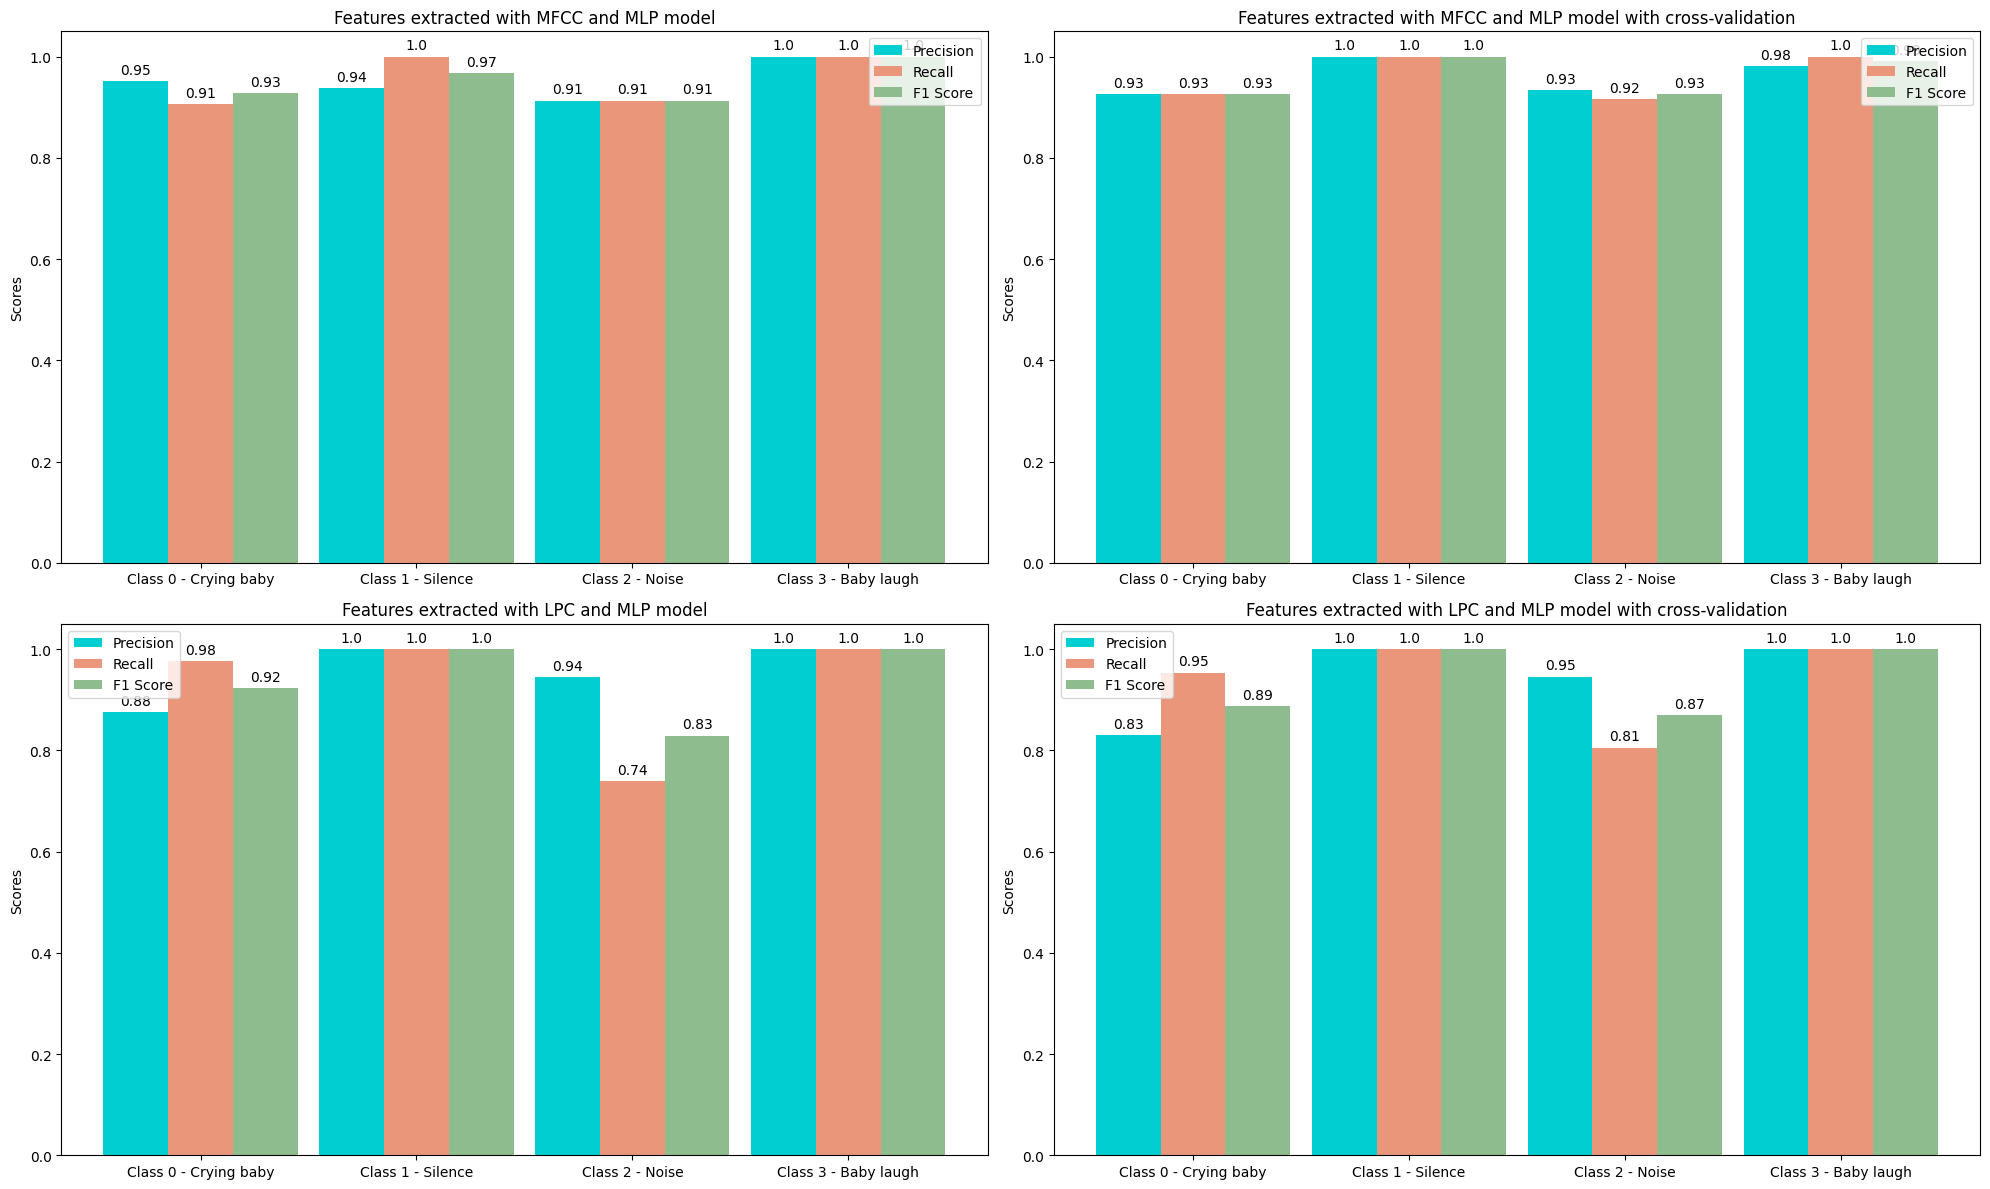

In [45]:
plot_classification_metrics_multiple(y_tests, y_preds, titles)